### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import itertools

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical 

# plotting
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import scikitplot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Load Dataset

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y_train = pd.DataFrame(df_train['label'])
x_train = pd.DataFrame(df_train.drop('label', axis =1))

In [4]:
print(f'X_train : {x_train.shape}')
print(f'y_train : {y_train.shape}')

X_train : (42000, 784)
y_train : (42000, 1)


In [5]:
y_train.value_counts()

label
1        4684
7        4401
3        4351
9        4188
2        4177
6        4137
0        4132
4        4072
8        4063
5        3795
dtype: int64

### Sample Images

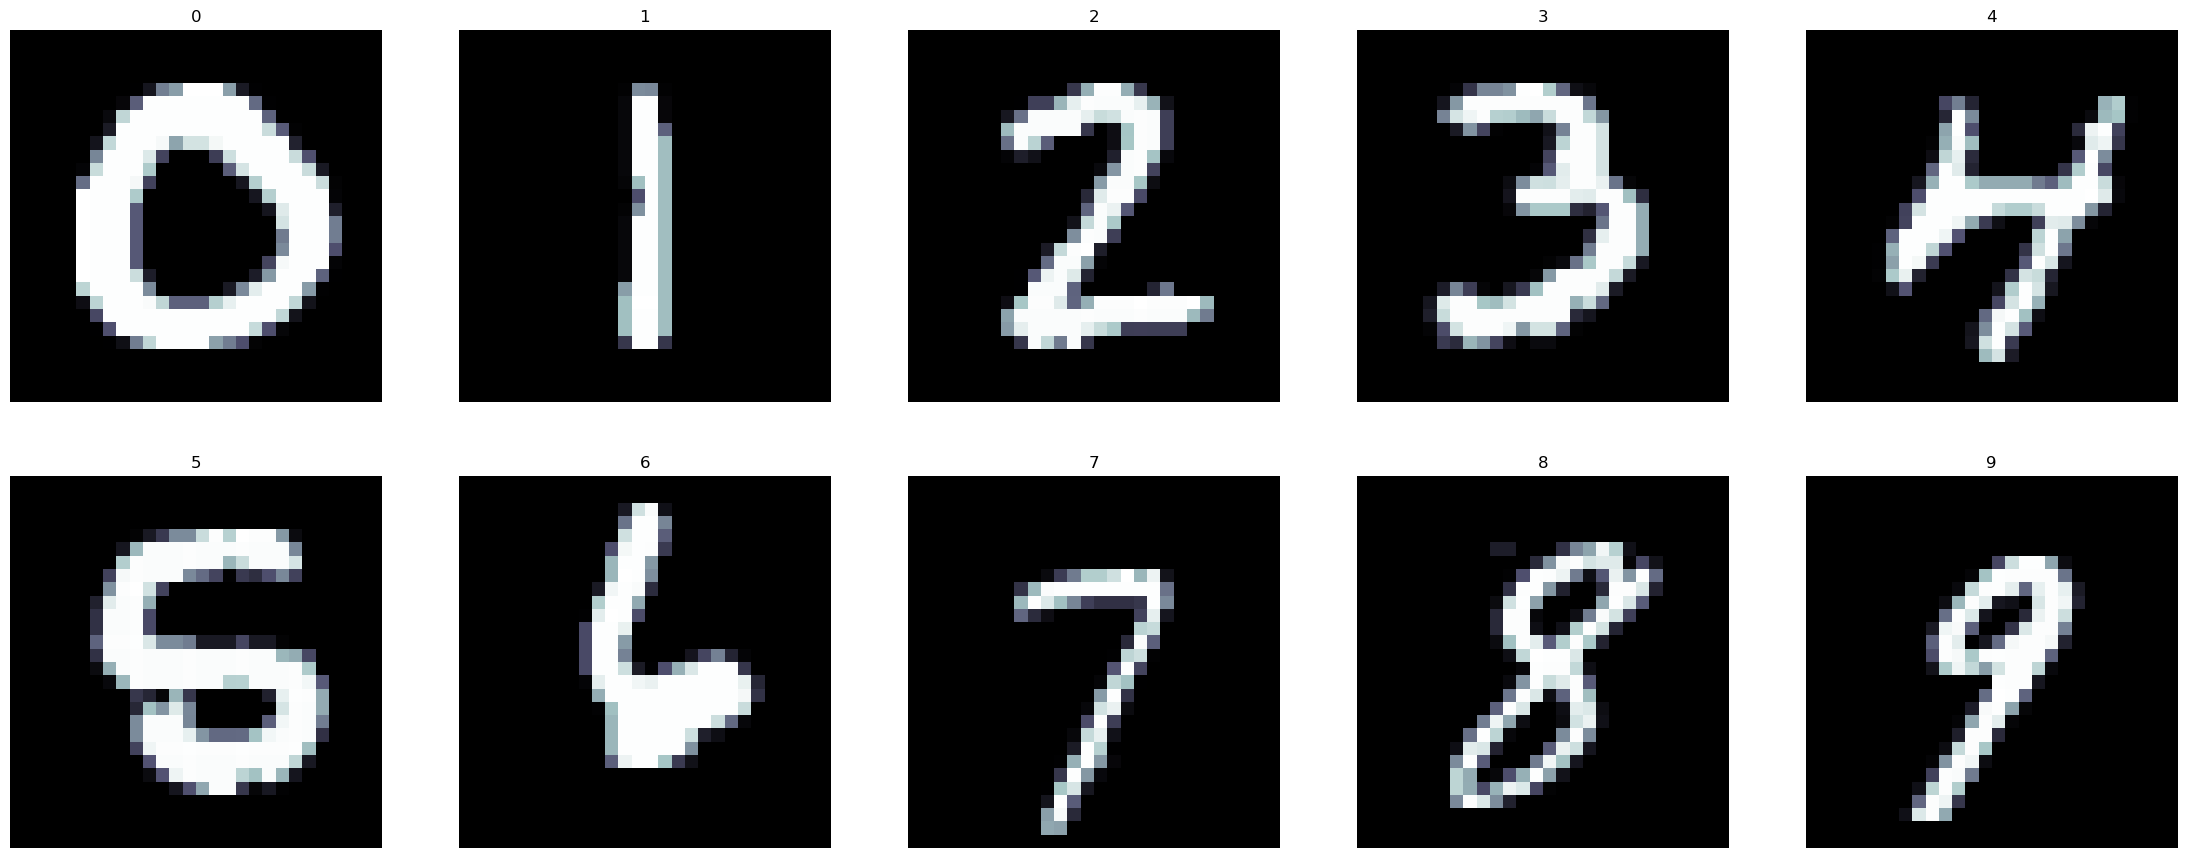

In [6]:
fig = plt.figure(1, (28,28))
k = 1
for label in sorted(df_train.label.unique()):
    px = df_train[df_train.label == label].iloc[1].values
    title = px[0]
    px = px[1:]
    px = px.reshape(28,28).astype('float32')
    ax = plt.subplot(5,5,k)
    k+=1
    ax.imshow(px, cmap = 'bone')
    plt.title(title)
    plt.axis("off")

### Image Preprocessing
#### 1. Pixel Conversion Suitable for Neural Network

In [7]:
x_train = x_train.values.reshape(-1,28,28,1)
print("x_train shape: ",x_train.shape)

x_train shape:  (42000, 28, 28, 1)


#### 2. Encoding

In [8]:
Y_train = to_categorical(y_train, num_classes = 10)
Y_train.shape

(42000, 10)

#### 3. Normalization

In [9]:
x_train = x_train / 255.0
print("x_train shape: ",x_train.shape)

x_train shape:  (42000, 28, 28, 1)


### Data Spliting

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, Y_train, test_size = 0.1, random_state = 42)

print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


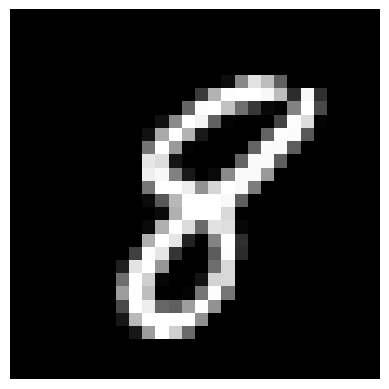

In [11]:
plt.imshow(X_val[4][:,:,0], cmap='gray')
plt.axis("off")
plt.show()

### Defining Data

In [12]:
width = X_train.shape[1]
height = X_train.shape[2]
depth = X_train.shape[3]
labels = Y_train.shape[1]

In [13]:
print('Width : ',width)
print('Height : ',height)
print('Depth : ',depth)
print('Labels : ',labels)

Width :  28
Height :  28
Depth :  1
Labels :  10


### Modeling

In [14]:
model = Sequential()
# first layer
model.add(Conv2D(filters = 6, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# second layer
model.add(Conv2D(filters = 16, kernel_size = (5,5), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected layer
model.add(Flatten())
model.add(Dense(120, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(labels))  
model.add(Activation('softmax'))

In [15]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 16)          0

In [16]:
model.compile(optimizer = optimizer , loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
epochs = 20  # for better result increase the epochs
batch_size = 250

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [19]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/20
151/151 [==============================] - 3s 21ms/step - loss: 1.3798 - accuracy: 0.5280 - val_loss: 0.2709 - val_accuracy: 0.9276
Epoch 2/20
151/151 [==============================] - 3s 20ms/step - loss: 0.5738 - accuracy: 0.8190 - val_loss: 0.1526 - val_accuracy: 0.9562
Epoch 3/20
151/151 [==============================] - 3s 20ms/step - loss: 0.4279 - accuracy: 0.8665 - val_loss: 0.1255 - val_accuracy: 0.9581
Epoch 4/20
151/151 [==============================] - 3s 20ms/step - loss: 0.3703 - accuracy: 0.8862 - val_loss: 0.1116 - val_accuracy: 0.9667
Epoch 5/20
151/151 [==============================] - 3s 20ms/step - loss: 0.3248 - accuracy: 0.9003 - val_loss: 0.0940 - val_accuracy: 0.9714
Epoch 6/20
151/151 [==============================] - 3s 20ms/step - loss: 0.2923 - accuracy: 0.9102 - val_loss: 0.0874 - val_accuracy: 0.9726
Epoch 7/20
151/151 [==============================] - 3s 20ms/step - loss: 0.2762 - accuracy: 0.9147 - val_loss: 0.0788 - val_accuracy: 0.9755

### Plotting Performance

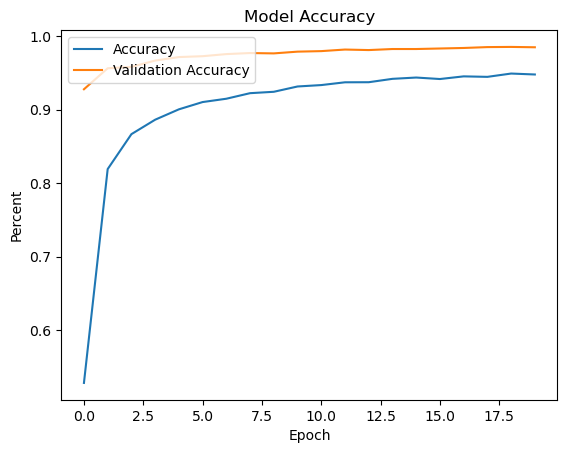

In [20]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Percent')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

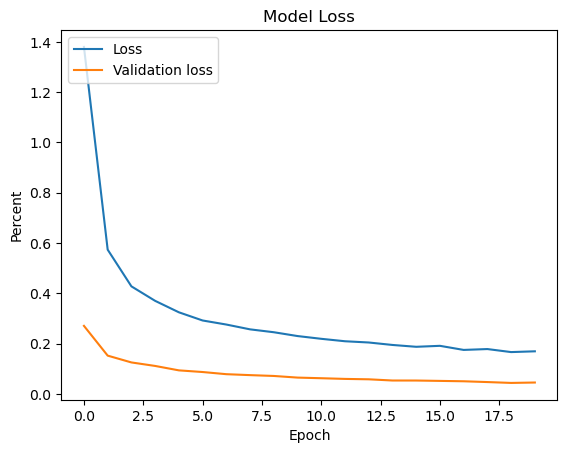

In [21]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Percent')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

### Confusion Matrix

132/132 [==============================] - 0s 1ms/step


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

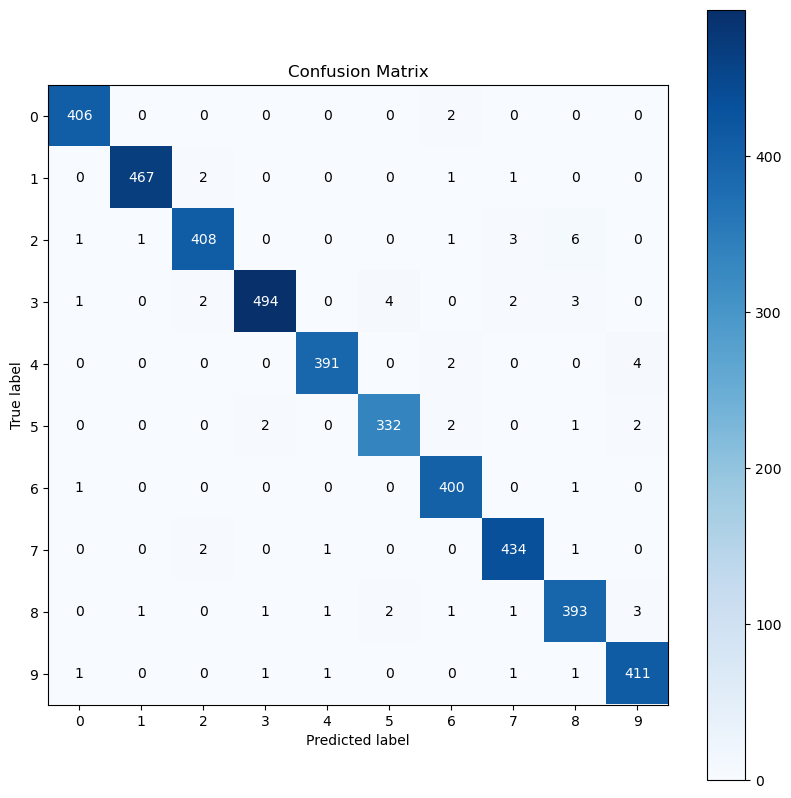

In [22]:
y_test = np.argmax(Y_val,axis=1)
y_pred = np.argmax(model.predict(X_val),axis=1)
scikitplot.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10,10))

In [23]:
print(f'total wrong validation predictions: {np.sum(y_test!= y_pred)}\n\n')
print(classification_report(y_test, y_pred))

total wrong validation predictions: 64


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       408
           1       1.00      0.99      0.99       471
           2       0.99      0.97      0.98       420
           3       0.99      0.98      0.98       506
           4       0.99      0.98      0.99       397
           5       0.98      0.98      0.98       339
           6       0.98      1.00      0.99       402
           7       0.98      0.99      0.99       438
           8       0.97      0.98      0.97       403
           9       0.98      0.99      0.98       416

    accuracy                           0.98      4200
   macro avg       0.98      0.98      0.98      4200
weighted avg       0.98      0.98      0.98      4200



In [24]:
errors = (y_pred - y_test != 0)
Y_pred_classes_errors = y_pred[errors]
Y_pred = model.predict(X_val)
Y_pred_errors = Y_pred[errors]
Y_true_errors = y_test[errors]
X_val_errors = X_val[errors]

Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

132/132 [==============================] - 0s 1ms/step


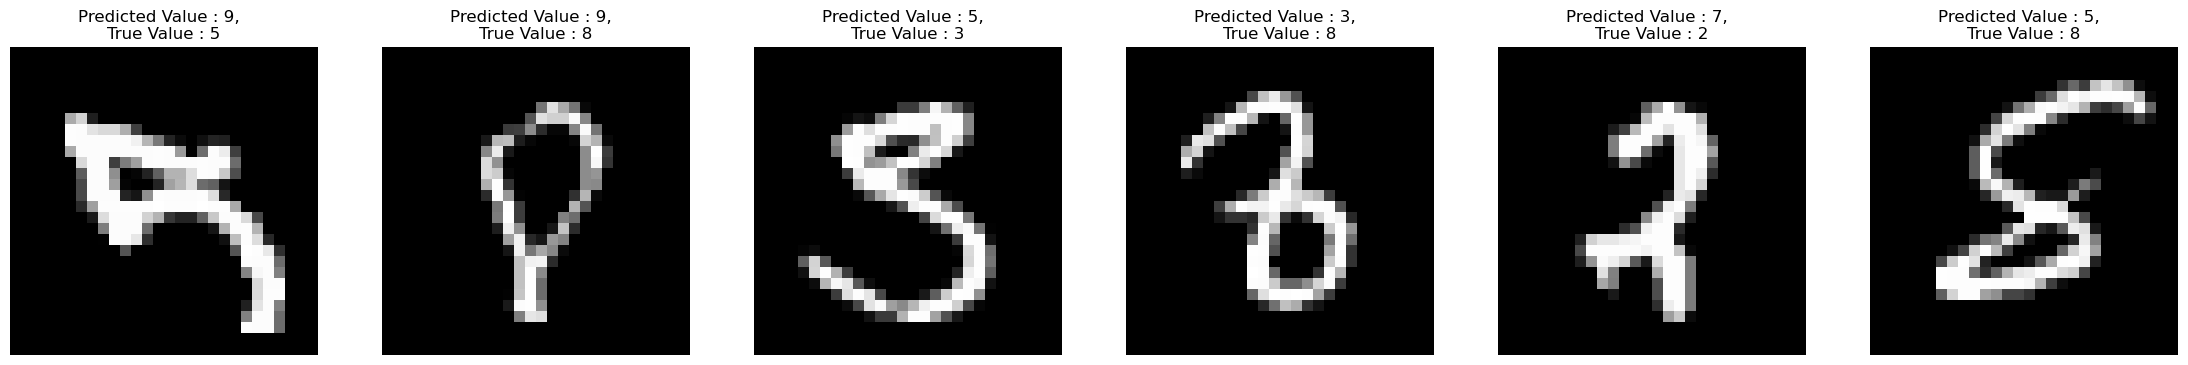

In [25]:
fig = plt.figure(1, (28,28))
k = 1
lst = [3, 48, 51, 40, 27, 0]
for label in lst:
    ax = plt.subplot(6,6,k)
    k+=1
    plt.imshow(X_val_errors[label][:,:,0], cmap='gray')
    plt.title(f"Predicted Value : {Y_pred_classes_errors[label]},  \nTrue Value : {Y_true_errors[label]}")
    plt.axis("off")

### Model Saving

In [26]:
from tensorflow.keras.models import load_model
model.save('./cnnmodel.h5')